In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'preprocessed_reduced_pcaSC.xlsx'

# Read the Excel file into a pandas DataFrame
reduced_pcaSC = pd.read_excel(file_name)

#Splitting data into answers for work_styles test

In [ ]:
work_styles = reduced_pcaSC[reduced_pcaSC['maingroup'] == 'tests.workstyles.title']
len(work_styles.question_id.unique())

# Above gives: array(['Gerichtheid op mensen', 'Sociale invloed', 'Aanpassingsvermogen',
#       'Zorgvuldigheid', 'Praktisch inzicht', 'Prestatiegerichtheid',
#       'Onafhankelijkheid'], dtype=object)

#Is the same as:
# People orientation, Social influence, Adaptability, diligence, Practical insight, Performance orientation, Independence

4

In [ ]:
# Specify the column names you want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
wrk_s = work_styles.loc[:, columns_to_keep]

wrk_s = wrk_s.drop(['maingroup'], axis=1)
qs = wrk_s.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# Same process as shown and explained in personality notebook
count_peo_o = 1
count_si = 1
count_a2 = 1
count_d2 = 1
count_pi = 1
count_per_o = 1
count_i3 = 1

for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Gerichtheid op mensen':
        qs.at[index, 'short_name'] = f'peo{count_peo_o}'
        count_peo_o += 1

    elif row['level1subgroup'] == 'Sociale invloed':
        qs.at[index, 'short_name'] = f'sin{count_si}'
        count_si += 1

    elif row['level1subgroup'] == 'Aanpassingsvermogen':
        qs.at[index, 'short_name'] = f'ada{count_a2}'
        count_a2 += 1

    elif row['level1subgroup'] == 'Zorgvuldigheid':
        qs.at[index, 'short_name'] = f'dil{count_d2}'
        count_d2 += 1

    elif row['level1subgroup'] == 'Praktisch inzicht':
        qs.at[index, 'short_name'] = f'pin{count_pi}'
        count_pi += 1

    elif row['level1subgroup'] == 'Prestatiegerichtheid':
        qs.at[index, 'short_name'] = f'per{count_per_o}'
        count_per_o += 1

    else:
        qs.at[index, 'short_name'] = f'inde{count_i3}'
        count_i3 += 1

qs

,question_id,level1subgroup,short_name
39,2403,Gerichtheid op mensen,peo1
40,2402,Gerichtheid op mensen,peo2
41,2401,Gerichtheid op mensen,peo3
42,2410,Onafhankelijkheid,inde1


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(work_styles, n_qs, on='question_id', how='left')
new_qs.head(3)

,question_id,dossier_id,answeredTest_id,question,type,label,datetime,maingroup,maingroup_id,faculty,level1subgroup,level1subgroup_id,answer,short_name
0,2403,1532,13165,question.id_2403,likert/likert6puntsmatepositief,Om mijn werk goed te doen is het belangrijk om...,2021-09-15 13:53:51,tests.workstyles.title,516,Faculteit Betawetenschappen,Gerichtheid op mensen,526,1.0,peo1
1,2402,1532,13165,question.id_2402,likert/likert6puntsmatepositief,Om mijn werk goed te doen is het belangrijk om...,2021-09-15 13:53:52,tests.workstyles.title,516,Faculteit Betawetenschappen,Gerichtheid op mensen,526,0.8,peo2
2,2401,1532,13165,question.id_2401,likert/likert6puntsmatepositief,Om mijn werk goed te doen is het belangrijk om...,2021-09-15 13:53:52,tests.workstyles.title,516,Faculteit Betawetenschappen,Gerichtheid op mensen,526,1.0,peo3


In [ ]:
# Create pivot table for Questions
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset the index of 'qs_data'
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)

# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,inde1,peo1,peo2,peo3
0,1532,0.4,1.0,0.8,1.0
1,1649,0.4,0.6,0.8,1.0
2,2112,0.6,0.8,0.8,1.0
3,30690,0.4,0.8,0.4,0.6
4,42388,0.8,0.8,0.6,0.6
...,...,...,...,...,...
392,91848,0.6,1.0,1.0,0.8
393,91894,0.8,0.6,0.6,0.8
394,91927,0.6,0.6,0.8,0.8
395,91928,0.8,0.6,0.6,1.0


In [ ]:
model = qs_data.drop('dossier_id', axis=1)
model

# Collect data for LCA before possible K-Means manipulation
data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# creating X variable to use as to not effect the model data
X = model

# Define the range of cluster numbers to test
n_clusters_range = range(2, 10)

# Initialize dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)

# Convert the metrics dictionary to dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.303126,155.568225,1.355272,2
1,0.222524,134.725896,1.332739,3
2,0.212795,125.170123,1.430867,4
3,0.232159,119.421126,1.294089,5
4,0.240147,117.570735,1.255909,6
5,0.221283,108.897455,1.245944,7
6,0.224981,101.542183,1.300260,8
7,0.229539,98.410437,1.366721,9


<Axes: xlabel='PC1', ylabel='PC2'>

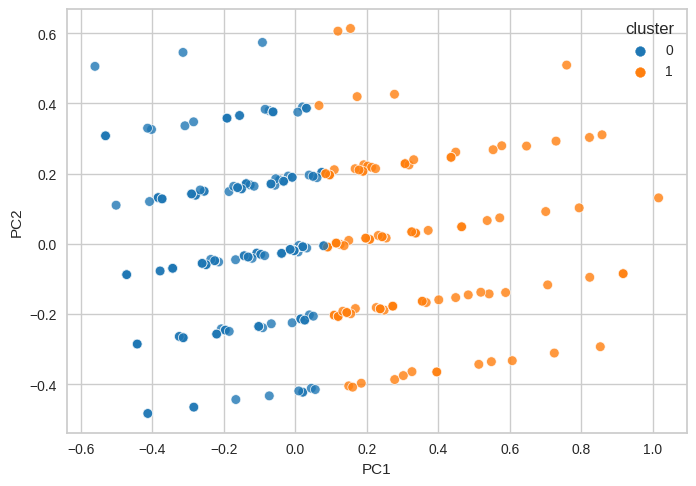

In [ ]:
# Creating K-means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette='tab10', alpha=0.8)

In [ ]:
#pca_data.to_excel('pcaSC_work_s_clusters.xlsx', index=False) # to be used for comparison in personality notebook

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid

# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 11.01it/s, max_LL=-1.22e+3, max_avg_LL=-3.06]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.9513 0.0487 0.0000 0.0000 0.0000 0.0000 0.4004 0.5996 0.0000 0.0000
 0.0000 0.0000 0.6280 0.3720 0.0000 0.0000 0.0000 0.0000 0.2687 0.7313
 0.0000 0.0000 0.0000 0.0000 0.6419 0.0000 0.0000 0.0310 0.3271 0.0000]
        Class 2 : [0.9357 0.0643 0.0000 0.0000 0.0000 0.0000 0.9714 0.0286 0.0000 0.0000
 0.0000 0.0000 0.9641 0.0359 0.0000 0.0000 0.0000 0.0000 0.8975 0.1025
 0.0000 0.0000 0.0000 0.0000 0.1417 0.2771 0.1703 0.2136 0.1139 0.0835]
    Class weights
        Class 1 : 0.25
        Class 2 : 0.75
    Fit for 2 latent classes
    Estimation method         

Initializations (n_init) : 100%|██████████| 10/10 [00:04<00:00,  2.38it/s, max_LL=-1.19e+3, max_avg_LL=-2.98]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.7621 0.2379 0.0000 0.0000 0.0000 0.0000 0.9869 0.0131 0.0000 0.0000
 0.0000 0.0000 0.9867 0.0133 0.0000 0.0000 0.0000 0.0000 0.9735 0.0265
 0.0000 0.0000 0.0000 0.0000 0.0411 0.0000 0.6435 0.0000 0.0000 0.3154]
        Class 2 : [0.9394 0.0606 0.0000 0.0000 0.0000 0.0000 0.3616 0.6384 0.0000 0.0000
 0.0000 0.0000 0.6003 0.3997 0.0000 0.0000 0.0000 0.0000 0.2202 0.7798
 0.0000 0.0000 0.0000 0.0000 0.6645 0.0000 0.0000 0.0125 0.3230 0.0000]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9495 0.0505 0.0000 0.0000
 0.0000 0.0000 0.9484 0.0516 0.000

Initializations (n_init) : 100%|██████████| 10/10 [00:03<00:00,  3.13it/s, max_LL=-1.17e+3, max_avg_LL=-2.94]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.9059 0.0941 0.0000 0.0000 0.0000 0.0000 0.7788 0.2212
 0.0000 0.0000 0.0000 0.0000 0.2429 0.5824 0.0000 0.0000 0.1747 0.0000]
        Class 2 : [0.9402 0.0598 0.0000 0.0000 0.0000 0.0000 0.3299 0.6701 0.0000 0.0000
 0.0000 0.0000 0.6195 0.3805 0.0000 0.0000 0.0000 0.0000 0.2289 0.7711
 0.0000 0.0000 0.0000 0.0000 0.6535 0.0000 0.0000 0.0290 0.3175 0.0000]
        Class 3 : [0.7130 0.2870 0.0000 0.0000 0.0000 0.0000 0.9841 0.0159 0.0000 0.0000
 0.0000 0.0000 0.9841 0.0159 0.000

Initializations (n_init) : 100%|██████████| 10/10 [00:12<00:00,  1.26s/it, max_LL=-1.16e+3, max_avg_LL=-2.93]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.9472 0.0528 0.0000 0.0000
 0.0000 0.0000 0.9475 0.0525 0.0000 0.0000 0.0000 0.0000 0.9414 0.0586
 0.0000 0.0000 0.0000 0.0000 0.0548 0.0000 0.7877 0.0000 0.0000 0.1575]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.9799 0.0201
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.2959 0.4657 0.0576 0.1808]
        Class 3 : [0.9237 0.0763 0.0000 0.0000 0.0000 0.0000 0.2928 0.7072 0.0000 0.0000
 0.0000 0.0000 0.5319 0.4681 0.000

Initializations (n_init) : 100%|██████████| 10/10 [00:08<00:00,  1.12it/s, max_LL=-1.16e+3, max_avg_LL=-2.92]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0005 0.0000 0.2501 0.3968 0.1831 0.1695]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.9204 0.0796 0.0000 0.0000 0.0000 0.0000 0.7796 0.2204
 0.0000 0.0000 0.0000 0.0000 0.3210 0.6206 0.0265 0.0000 0.0320 0.0000]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5122 0.4878 0.0000 0.0000
 0.0000 0.0000 0.5783 0.4217 0.000

Initializations (n_init) : 100%|██████████| 10/10 [00:08<00:00,  1.12it/s, max_LL=-1.16e+3, max_avg_LL=-2.91]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0336 0.0281 0.2410 0.3710 0.1658 0.1605]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.6619 0.3381
 0.0000 0.0000 0.0000 0.0000 0.2337 0.7190 0.0378 0.0002 0.0093 0.0000]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5039 0.4961 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.000

Initializations (n_init) : 100%|██████████| 10/10 [00:08<00:00,  1.18it/s, max_LL=-1.16e+3, max_avg_LL=-2.91]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.6087 0.3913
 0.0000 0.0000 0.0000 0.0000 0.2335 0.7207 0.0379 0.0003 0.0075 0.0000]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.7725 0.2275 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.3908 0.4988 0.0000 0.0000 0.1103 0.0000]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5038 0.4962 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.000

Initializations (n_init) : 100%|██████████| 10/10 [00:13<00:00,  1.36s/it, max_LL=-1.15e+3, max_avg_LL=-2.91]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 5 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.9380 0.0620 0.0000 0.0000
 0.0000 0.0000 0.9380 0.0620 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.8140 0.0000 0.0000 0.1860]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.1575 0.3151 0.0071 0.2554 0.2649 0.0001]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5082 0.4918 0.0000 0.0000
 0.0000 0.0000 0.5885 0.4115 0.000

In [ ]:
results

,param_n_steps,param_n_components,aic,bic
0,1,2,2529.924790,2725.137668
1,1,3,2518.000971,2812.812256
2,1,4,2536.192858,2930.602550
3,1,5,2572.408293,3066.416392
4,1,6,2614.663929,3208.270435
5,1,7,2659.242332,3352.447245
6,1,8,2709.242329,3502.045649
7,1,9,2756.876572,3649.278298
